<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#Selecting-Sig-Data" data-toc-modified-id="Selecting-Sig-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Selecting Sig Data</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span></li></ul></div>

# Preamble

In [1]:
##############################
''' Packages '''
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from dask.diagnostics import ProgressBar
# ProgressBar().register()
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
rb = plt.cm.RdBu
bm = plt.cm.Blues



In [2]:
int_name = 'Proportion'

In [3]:
directory = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/prop_data/'
save_dir = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/prop_plot/'

In [4]:
path = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/RMM.pickle'
pickle_in = open(path, 'rb')
RMM = pickle.load(pickle_in)

RMM = RMM.reset_index()
RMM = RMM.rename({'Date':'time'}, axis = 1)
RMM = RMM.set_index(['time'])

In [5]:
path = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/station_xr.nc'
MJO_station = xr.open_mfdataset(path)
station_xr = MJO_station.sel(time = slice(RMM.index[0], '2010'))

In [6]:
path = directory  + 'station_prop_90.nc'
station_90 = xr.open_dataset(path)

In [7]:
path = directory  + 'station_prop_95.nc'
station_95 = xr.open_dataset(path)

In [8]:
path = directory  + 'station_prop_boot_90.nc'
station_boot_90 = xr.open_dataset(path)

In [9]:
path = directory  + 'station_prop_boot_95.nc'
station_boot_95 = xr.open_dataset(path)

In [10]:
def correct_dataset(extreme, original):
    dataset = xr.Dataset({'precip':(('mjo','location','month'),np.array(extreme.precip.values)),
                         'station_name':(('location'), original.station_name),
                          'lat':(('location'), original.lat),
                         'lon':(('location'), original.lon)
                         },
                         {'mjo': ['enhanced', 'suppressed', 'inactive'], 'location':original.location, 'month':
                         [10,11,12,1,2,3]}
                        )
    return dataset
    

In [11]:
station_90 = correct_dataset(station_90, station_xr)

# Selecting Sig Data

In [12]:
# THis function return an array that contains only values for the signficant points

def sel_sig(normal, boot):
    
    
    # The enhanced phase where we only want the points that are greater than 1
    name = 'enhanced'
    normal_en = normal.sel(mjo = name)
    boot_en = boot.sel(mjo = name)
    
    station_sig_en = normal_en.precip.where(
    np.logical_and(
        boot_en.isel(percentile = 0).precip >= 1, 
        boot_en.isel(percentile = 1).precip >= 1)
        )
    
    # The suppressed phase where we only want the points that are less than 1
    name = 'suppressed'
    normal_sup = normal.sel(mjo = name)
    boot_sup = boot.sel(mjo = name)
    
    station_sig_sup = normal_sup.precip.where(
    np.logical_and(
        boot_sup.isel(percentile = 0).precip <= 1, 
        boot_sup.isel(percentile = 1).precip <= 1)
    )
    
        
    station_sig =  xr.concat([station_sig_en, station_sig_sup], pd.Index(['enhanced','suppressed'], name = 'mjo'))
    
    return station_sig

In [26]:
station_boot_90

<xarray.Dataset>
Dimensions:     (location: 32, mjo: 2, month: 6, percentile: 2)
Coordinates:
  * month       (month) int64 1 2 3 10 11 12
  * location    (location) object '5004' '5008' '5014' '4006' '3028' '3030' ...
  * percentile  (percentile) object '90' '10'
  * mjo         (mjo) object 'enhanced' 'suppressed'
Data variables:
    precip      (mjo, percentile, location, month) float64 1.386 1.231 1.417 ...

In [13]:
station_90_sig = sel_sig(station_90, station_boot_90)


station_90_sig = station_90_sig.assign_coords(lat = station_90.lat)
station_90_sig = station_90_sig.assign_coords(lon = station_90.lon)

In [60]:
station_90_sig.sel(mjo = 'enhanced', month = 2)

<xarray.DataArray 'precip' (location: 32)>
array([     nan,      nan, 1.410567, 1.169926, 1.431076, 1.452045,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan])
Coordinates:
    month     int64 2
  * location  (location) object '5004' '5008' '5014' '4006' '3028' '3030' ...
    mjo       <U8 'enhanced'
    lat       (location) float64 -22.38 -21.19 -21.79 -22.18 -19.25 -18.68 ...
    lon       (location) float64 114.1 116.0 117.9 119.9 121.5 121.8 123.7 ...

# Plots

In [14]:
class MidpointNormalizeLog(colors.LogNorm):
    def __init__(self, vmin, vmax, midpoint):
        self.midpoint = midpoint
        super().__init__(vmin=vmin, vmax=vmax)
        
    def __call__(self, value, clip=None):
        original = super().__call__(value, clip)
        procmid = super().__call__(self.midpoint, clip)
        
        x, y = [0, procmid, 1], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(original, x, y), np.isnan(original))

In [15]:
import datetime as dt

In [16]:
def plot_sig_and_norm(data_all_sub, data_sig_sub, ax):
    
    
    vmax = 2.5
    vmin = 0.5
    size = 200
    
    # Plotting all the points
  
    plot_data = plt.scatter(data_all_sub.lon.values,data_all_sub.lat, s = size,c = data_all_sub.precip,
                            edgecolor = 'k', cmap = rb,
                norm =  MidpointNormalizeLog(vmin = vmin, vmax = vmax, midpoint=1))
    

    # Now for the significant we want to drop all the points that aren't significant, and then plot just an 'x'
    
    data_sig_sub = data_sig_sub.dropna(dim = 'location')
    plt.scatter(data_sig_sub.lon.values,data_sig_sub.lat, s = size - 75, c = 'k', marker = 'x')

    # Coastlines
#     ax.coastlines()
    ax.coastlines(resolution  = '50m')
  
    
    
    return plot_data

In [68]:
def station_plot(data_all, data_sig, save_fig = 0, title = ''):
    fig = plt.figure(figsize  = (12,8), dpi = 400)
    
   
    
    month_name = dt.date(2015, int(month), 1).strftime('%B')
    title = str(month_name) + " : " 
    title_size =15
    fig.suptitle(title, fontsize = title_size)

    
    plot_num = 1
    # Plotting the enhanced phase
    name = 'enhanced'
    
    ax = fig.add_subplot(2,1,plot_num,projection = ccrs.PlateCarree())

    data_all_sub = data_all.sel(mjo = name)
    data_sig_sub = data_sig.sel(mjo = name)
    _ = plot_sig_and_norm(data_all_sub, data_sig_sub, ax)
    
    
    # Plotting the suppressed phase
    plot_num += 1
    name = 'suppressed'
    
    ax = fig.add_subplot(2,1,plot_num,projection = ccrs.PlateCarree())

    data_all_sub = data_all.sel(mjo = name)
    data_sig_sub = data_sig.sel(mjo = name)
    plot_data = plot_sig_and_norm(data_all_sub, data_sig_sub, ax)
    
    ###### Row Labels
#     plt.text(100,1,'hello')
    
    xdip = 106
    plt.text(xdip,-4,'Enhanced', fontsize = title_size )
    plt.text(xdip,-18,'Suppressed', fontsize = title_size )
    
    
    
    ###### Color Bar

    ticks= np.array([0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2])
    tick_labels = [str(i) for i in ticks]
    ticks = ticks - 0.05
    step = 0.1
#     boundaries = np.arange(0.1,vmax - step,step)
    cax = fig.add_axes([.3, 0.9, 0.4,0.01])

    cbar = plt.colorbar(plot_data, orientation = 'horizontal',ticks= ticks, cax = cax,
                           extend = 'both')




    #     ticks[0] -= 0.01
    # cbar.ax.tick_params(labelsize = 10)
    cbar.ax.set_xticklabels(tick_labels); 
    cbar.set_label('Ratio'
                  , fontsize = 12, labelpad = 10) 
    
    
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.83])
    

    if save_fig == 1:
        fig.savefig(save_dir + title + '.png', dpi = 400)

In [20]:
data_all

<xarray.Dataset>
Dimensions:       (location: 32, mjo: 3)
Coordinates:
  * mjo           (mjo) <U10 'enhanced' 'suppressed' 'inactive'
  * location      (location) object '5004' '5008' '5014' '4006' '3028' ...
    month         int64 1
Data variables:
    precip        (mjo, location) float64 0.8898 1.139 0.9797 0.9927 1.061 ...
    station_name  (location) object 'EXMOUTH GULF' 'MARDIE' 'MOUNT FLORANCE' ...
    lat           (location) float64 -22.38 -21.19 -21.79 -22.18 -19.25 ...
    lon           (location) float64 114.1 116.0 117.9 119.9 121.5 121.8 ...

/home/student.unimelb.edu.au/aborowiak/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


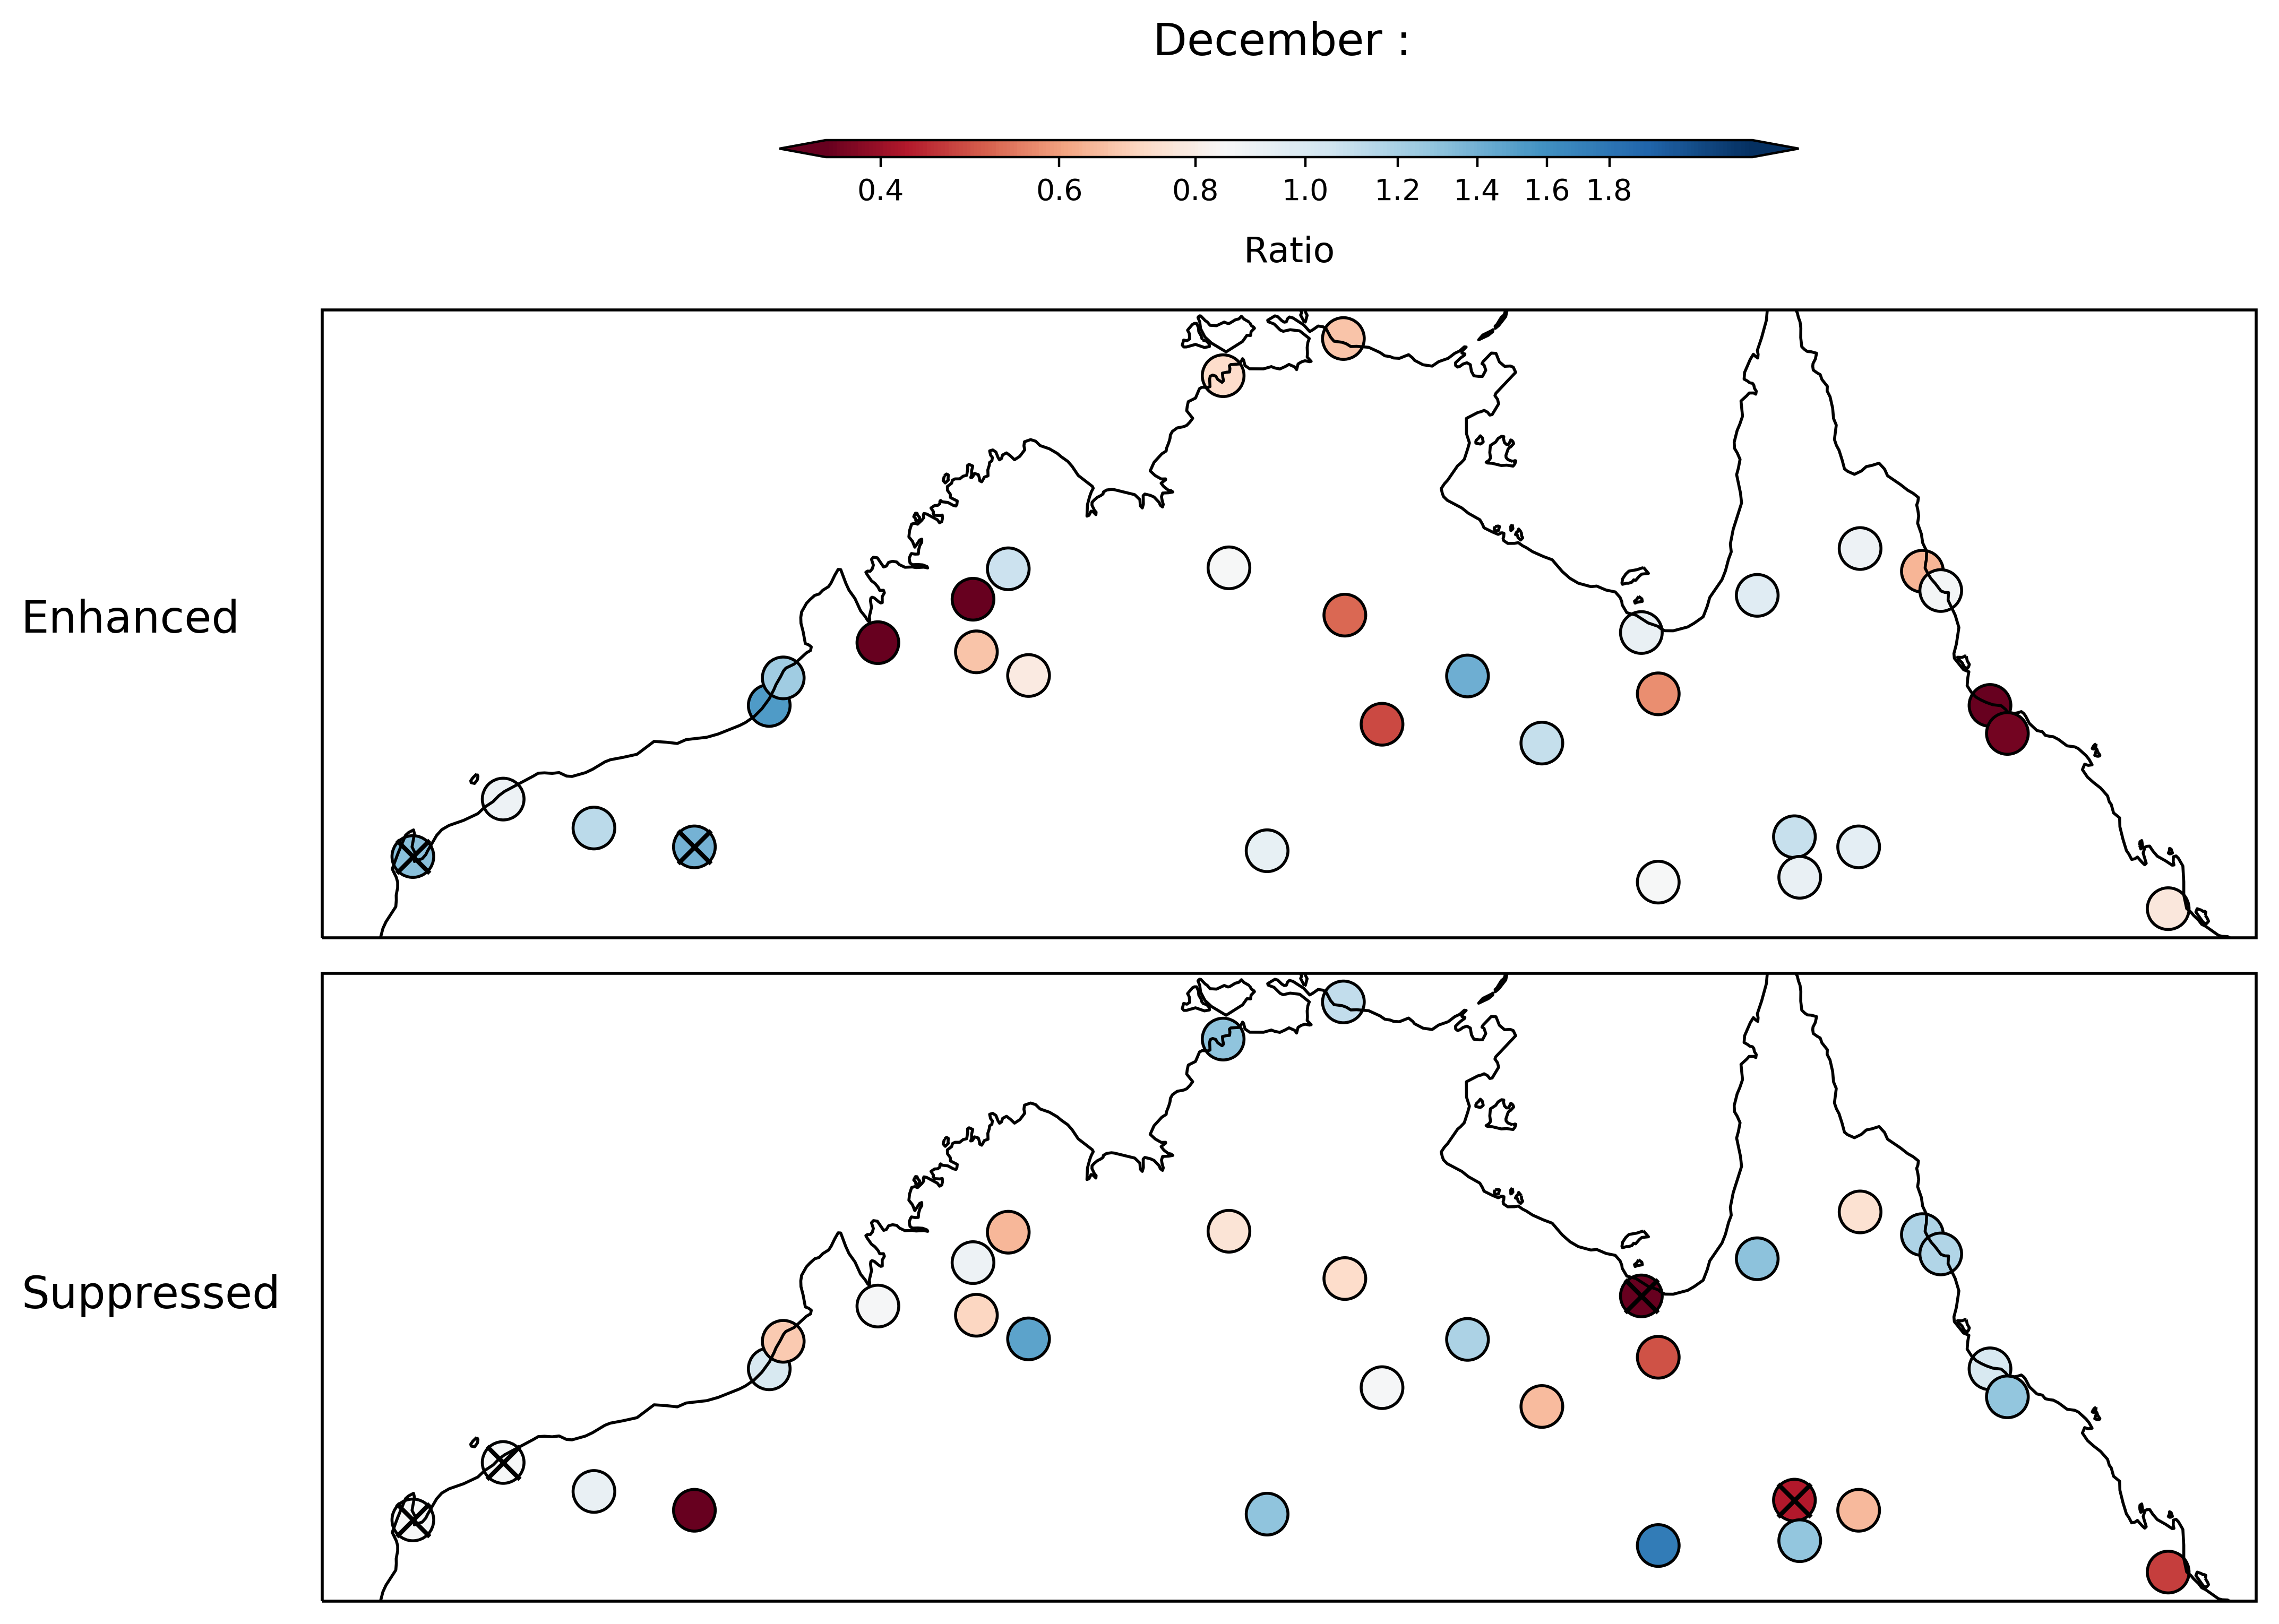

In [69]:

month = 12
title = int_name
data_all = station_90.sel(month = month)
data_sig = station_90_sig.sel(month = month)
save_fig = 0
station_plot(data_all, data_sig, title, save_fig)